# VGG 

In [1]:
#!pip install tensorflow xarray numpy wget
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/stages.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/full_models.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/loss.py

import numpy as np
import xarray as xr

from keras.models import Model
from keras.layers import Flatten, Dense, Reshape, Input, Conv2D, Masking, Concatenate, MaxPooling2D
from keras.optimizers import SGD
from keras.applications import VGG16
import tensorflow as tf
from stages import stage1
from full_models import vgg16_full
from loss import custom_loss

from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

2024-06-24 23:53:33.449409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 23:53:33.493122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Shallow learning (Stage 1)

In [2]:
stage1_model = stage1(1)

stage1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                              

In [3]:
input_shape = (128, 128, 3)
filters = 1

#### 2. VGG16
The pretrained VGG16 model (i.e., weights) is obtained from the Keras package (Chollet et al., 2015). The VGG16 model design consists of a series of downsampling convolutional layers (3 × 3 filter, ReLU activation function), interlaced with max pooling layers (2 × 2; Figure A1). The number of filters increases gradually from 64 to 512, while the size of the feature map decreases from 128 to 8 (in pixels). At the end, the convolutional layers are flattened and connected to a fully connected layer before reshaped to the dimensions of the output layer (i.e., 128 × 128). Linear activation function is used for the output layer.

In [4]:
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

#### 3. Combined model (Stage 2)

In [6]:
# for layer in conv_base.layers:
#     layer.trainable = False

# # add stage 1 layers
# top_layer = conv_base(stage1_model.output)

# # add a new top layer
# top_layer = Flatten()(top_layer)
# top_layer = Dense(128*128, activation='linear')(top_layer)
# top_layer = Reshape((128, 128, 1))(top_layer)

# full_model = Model(inputs=stage1_model.inputs, outputs=top_layer)
full_model = vgg16_full()
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking_3 (Masking)         (None, 128, 128, 3)          0         ['input_5[0][0]']             
                                                                                            

In [7]:
full_model.compile(optimizer = SGD(learning_rate = 0.01, weight_decay=1e-6, momentum=0.9), loss = custom_loss, metrics = [ 'mean_squared_error' ])

#### 4. Model training
Out of a total of 177 monthly data available for the study period, 125 months or 70% is used for training and the rest for testing.

In [8]:
precip_train = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(2,127)])
temp_train = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(2,127)])
twsa_train = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(2,127)])

precip_test = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(127,177)])
temp_test = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(127,177)])
twsa_test = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(127,177)])

mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')
mismatch = mismatch_ds['norm_mismatch'].to_numpy()[..., np.newaxis]
mismatch_train = mismatch[2:127]
mismatch_test = mismatch[127:177]

print(f'Number of training examples = {precip_train.shape[0]}')
print(f'Number of test examples = {precip_test.shape[0]}')

print(f'Training input shape: {precip_train.shape}')
print(f'Training output shape: {mismatch_train.shape}')
print(f'Test input shape: {precip_test.shape}')
print(f'Test output shape: {mismatch_test.shape}')

Number of training examples = 125
Number of test examples = 50
Training input shape: (125, 128, 128, 3)
Training output shape: (125, 128, 128, 1)
Test input shape: (50, 128, 128, 3)
Test output shape: (50, 128, 128, 1)


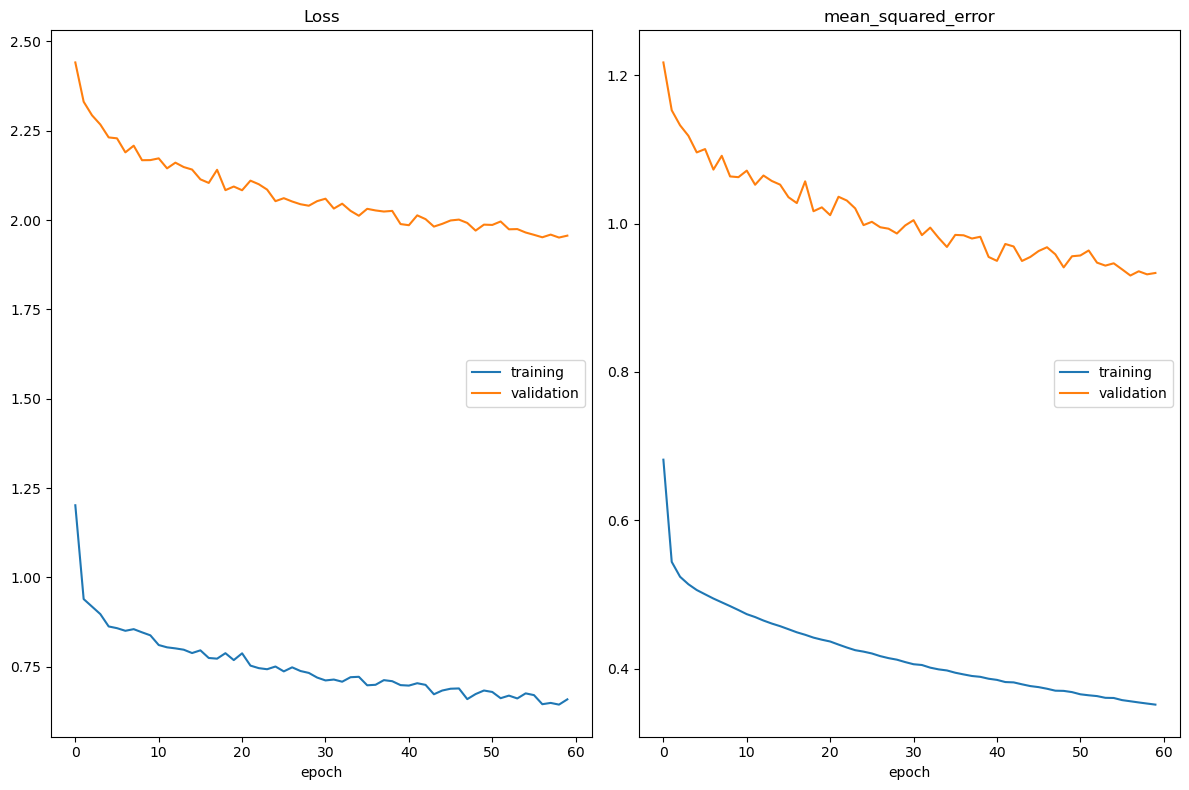

Loss
	training         	 (min:    0.644, max:    1.202, cur:    0.659)
	validation       	 (min:    1.951, max:    2.441, cur:    1.957)
mean_squared_error
	training         	 (min:    0.352, max:    0.682, cur:    0.352)
	validation       	 (min:    0.930, max:    1.217, cur:    0.933)
25/25 [==============================] - 19s 747ms/step - loss: 0.6589 - mean_squared_error: 0.3517 - val_loss: 1.9566 - val_mean_squared_error: 0.9334


In [9]:
full_model.fit(x=[precip_train, temp_train, twsa_train],
              y=mismatch_train,
              batch_size=5,
              epochs=60,
              validation_data=([precip_test, temp_test, twsa_test], mismatch_test),
              callbacks=[ModelCheckpoint(filepath='vgg.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1),
                         PlotLossesCallback()],
              verbose=1)

In [10]:
preds = full_model.evaluate([precip_test, temp_test, twsa_test], mismatch_test, batch_size=5)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 2s 209ms/step - loss: 1.9566 - mean_squared_error: 0.9334
Loss = 1.9565805196762085
Test Accuracy = 0.9333661794662476


In [11]:
pred_mismatch = full_model.predict([precip_test, temp_test, twsa_test], batch_size=5)

10/10 [==============================] - 2s 211ms/step


In [12]:
pred_mismatch_da = xr.DataArray(np.squeeze(pred_mismatch), coords={'time': mismatch_ds['time'][127:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])

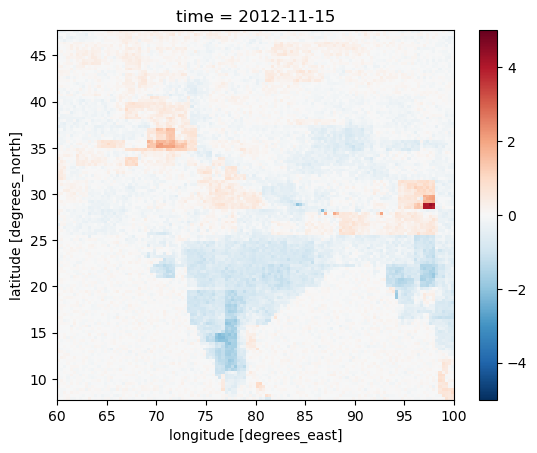

In [13]:
pred_mismatch_da[0,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

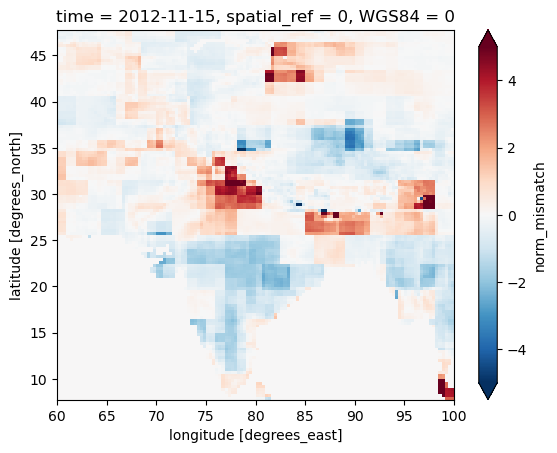

In [14]:
mismatch_ds['norm_mismatch'][127,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

#### 5. Save

In [15]:
# retrieve mean and std of the normalised mismatch to denormalize the output
diff_mean = mismatch_ds['norm_mismatch'].attrs['diff_mean']
diff_std = mismatch_ds['norm_mismatch'].attrs['diff_std']

In [16]:
full_pred_mismatch = full_model.predict([
    np.concatenate((precip_train, precip_test), axis=0),
    np.concatenate((temp_train, temp_test), axis=0),
    np.concatenate((twsa_train, twsa_test))
    ], batch_size=5)

full_pred_mismatch_da = xr.DataArray(np.squeeze(full_pred_mismatch), coords={'time': mismatch_ds['time'][2:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])
denorm_pred_da = full_pred_mismatch_da * diff_std + diff_mean
#denorm_pred_da = full_pred_mismatch_da * (diff_max - diff_min) + diff_min

# save the predicted mismatch
xr.merge([
    full_pred_mismatch_da.to_dataset(name='norm_mismatch_pred'),
    denorm_pred_da.to_dataset(name='mismatch_pred')
]).to_netcdf('./data/vgg16_output.nc4')

35/35 [==============================] - 7s 212ms/step
